# ASK
For this Business Task, We are required to outline actions to be considered by Key Stakeholders to enable the Organization strategize in converting Casual bike riders to Members. For this we would focus on the following:

1. How do annual members and casual riders use Cyclistic bikes differently?
2. Why would casual riders buy Cyclistic annual memberships?
3. How can Cyclistic use digital media to influence casual riders to become members?

# PREPARE
The data provided is a public dataset located [here](https://divvy-tripdata.s3.amazonaws.com/index.html). Information on the lincencing of this dataset can also be found [here](https://www.divvybikes.com/data-license-agreement). The 12 datasets reprensenting each month of the year 2020 was downloaded in in Zipped format. Each months data is in structured format, CSV type. The Columns are consistent throught out the individual months. The data appears to be Realiable, Original, Comprehensive, Current and Cited, therefore it can be trusted to perform our analysis.

# PROCESS
All Exploration and Data Analysis were carried out using R in RStudio. Every Cleaning, Transformation and Analysis process is well detailed below.

In [1]:
# Setting up envrionment
library(tidyverse)
library(dplyr)
library(lubridate)
library(geosphere)
library(naniar)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
# read CSV data
bike_rides <- read_csv("../input/cyclisticbikeridesdata/Bike Rides.csv")

Rows: 5595063 Columns: 13

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): ride_id, rideable_type, start_station_name, start_station_id, end_...
dbl  (4): start_lat, start_lng, end_lat, end_lng
dttm (2): started_at, ended_at


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [3]:
# Create new column for start and end time
bike_rides$start_hr <- hour(bike_rides$started_at)
bike_rides$end_hr <- hour(bike_rides$ended_at)

In [4]:
# Calculate trip duration in hours and minutes 
bike_rides$trip_hour <- as.numeric(difftime
                                (bike_rides$ended_at,bike_rides$started_at,
                                 units = c("hours")))

bike_rides$trip_minutes <- as.numeric(difftime
                                  (bike_rides$ended_at,bike_rides$started_at,
                                   units = c("mins")))

In [5]:
#Drop rows with less than 0 minutes trips and null cells
bike_rides <- bike_rides %>% filter(trip_minutes > 0)

we lose 653 trips from our dataframe

In [6]:
# Calculate distance between start and end stations
bike_rides <- bike_rides %>% mutate(
                    distance_km = (distHaversine(cbind(start_lng, start_lat),
                                     cbind(end_lng, end_lat)))/1000)

This information will only provide us with the distance between stations. Riders can take very long distance trips and return bikes to their initial pick-up station, resulting in a travelled distance of zero(0).
To better understand distance travelled by riders, odometers would have to added to the bikes.

In [7]:
# Extract day of week
bike_rides$start_wkday <- weekdays(bike_rides$started_at)
bike_rides$end_wkday <- weekdays(bike_rides$ended_at)

In [8]:
# Checking for duplicate rows using the ride_id column
bike_rides[duplicated(bike_rides$ride_id),]

ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_hr,end_hr,trip_hour,trip_minutes,distance_km,start_wkday,end_wkday
<chr>,<chr>,<dttm>,<dttm>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>


In [9]:
## check columns with NA and the NA distribution
colnames(bike_rides)[colSums(is.na(bike_rides)) > 0]
colSums(is.na(bike_rides))

[1] "start_station_name" "start_station_id"   "end_station_name"  
[4] "end_station_id"     "end_lat"            "end_lng"           
[7] "distance_km"

ride_id      rideable_type         started_at           ended_at 
                 0                  0                  0                  0 
start_station_name   start_station_id   end_station_name     end_station_id 
            690784             690781             738726             738726 
         start_lat          start_lng            end_lat            end_lng 
                 0                  0               4770               4770 
     member_casual           start_hr             end_hr          trip_hour 
                 0                  0                  0                  0 
      trip_minutes        distance_km        start_wkday          end_wkday 
                 0               4770                  0                  0

Our output shows that a majority of the missing data is from the columns that deal with location

In [10]:
## checking number of rows with null values
sum(!complete.cases(bike_rides))/5594410

[1] 0.1798771

Our output shows that a majority of the missing data is from the columns that deal with location.
We see that almost 20% of our dataframe contains null values this seems like a large amount of data to drop as this might skew our analysis.
We should try to analyse and see why we have such a large amount null rows.

In [11]:
 # Create dataframe for null rows
null_df <- bike_rides[rowSums(is.na(bike_rides)) > 0,]


### Investigate Null dataframe

In [12]:
count(null_df, rideable_type, sort=TRUE)

rideable_type,n
<chr>,<int>
electric_bike,997102
classic_bike,8910
docked_bike,294


In [13]:
head(count(null_df, start_station_name, rideable_type, sort = TRUE), n =10)

start_station_name,rideable_type,n
<chr>,<chr>,<int>
NA,electric_bike,690784
Kedzie Ave & Milwaukee Ave,electric_bike,2698
University Ave & 57th St,electric_bike,2309
Streeter Dr & Grand Ave,electric_bike,2226
Damen Ave & Pierce Ave,electric_bike,2208
Ellis Ave & 60th St,electric_bike,2131
California Ave & Milwaukee Ave,electric_bike,2095
Ashland Ave & Division St,electric_bike,2027
Wells St & Concord Ln,electric_bike,1912


In [14]:
count(null_df, rideable_type, member_casual, sort = TRUE)

rideable_type,member_casual,n
<chr>,<chr>,<int>
electric_bike,member,522053
electric_bike,casual,475049
classic_bike,casual,5019
classic_bike,member,3891
docked_bike,casual,294


In [15]:
count(null_df, member_casual, sort = TRUE)

member_casual,n
<chr>,<int>
member,525944
casual,480362


we see our null dataframe seems to be greatly centered around the type of bike (rideable_type) specifically Electric bikes as the biggest culprit. This could be an operational problem with bikes not registering location properly, this observation should be properly investigated to prevent future loss in data.

since the null having rows have other attributes important to our analysis, we’ll replace the null values in the start_station_name and end_station_name with “missing station”.

In [16]:
bike_rides$start_station_name[is.na(bike_rides$start_station_name)] = "missing station"

bike_rides$end_station_name[is.na(bike_rides$end_station_name)] = "missing station"

summary(bike_rides)

   ride_id          rideable_type        started_at                 
 Length:5594410     Length:5594410     Min.   :2021-01-01 00:02:05  
 Class :character   Class :character   1st Qu.:2021-06-06 23:48:04  
 Mode  :character   Mode  :character   Median :2021-08-01 01:47:45  
                                       Mean   :2021-07-29 07:38:35  
                                       3rd Qu.:2021-09-24 16:34:56  
                                       Max.   :2021-12-31 23:59:48  
                                                                    
    ended_at                   start_station_name start_station_id  
 Min.   :2021-01-01 00:08:39   Length:5594410     Length:5594410    
 1st Qu.:2021-06-07 00:39:47   Class :character   Class :character  
 Median :2021-08-01 02:16:53   Mode  :character   Mode  :character  
 Mean   :2021-07-29 08:00:31                                        
 3rd Qu.:2021-09-24 16:52:38                                        
 Max.   :2022-01-03 17:32:18      

We immediately see what look like strong outliers in our trip_minutes and trip_hours columns with the minimum trip taking 0.02 minutes and the maximum trip taking 932.4 hours (38.85 days), this could be possible as a rider could have rented the bike for that long or didn’t mind paying the extra fee charged for late returns as seen on the divvy bikes website.
we will further investigate these column to see just how much of our observations are outliers.

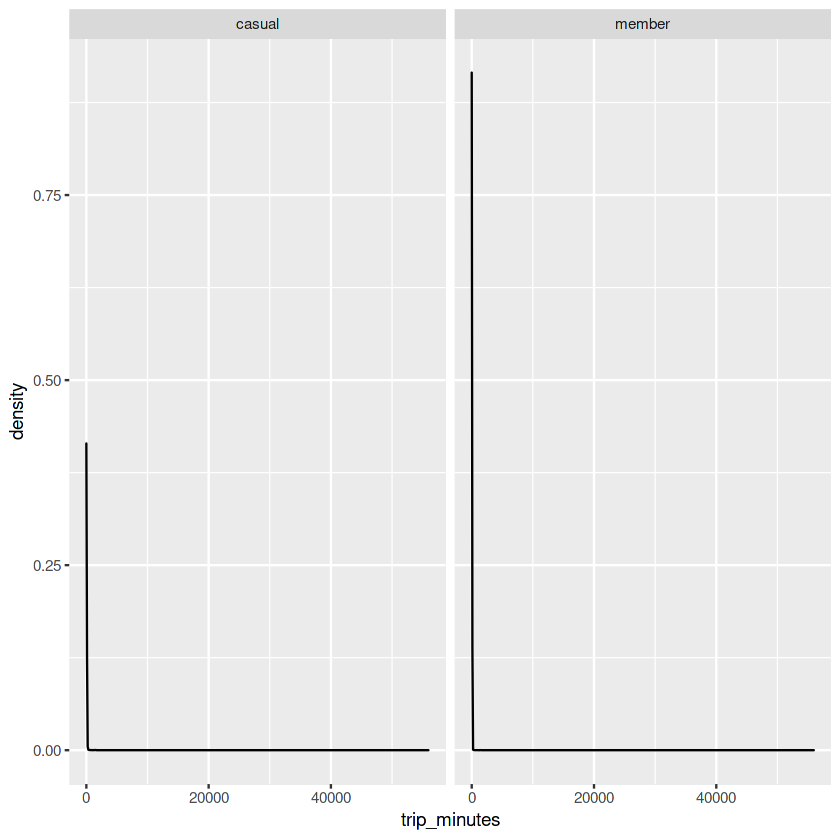

In [17]:
# Density plot
ggplot(bike_rides) +
  geom_density(mapping = aes(x=trip_minutes)) +
  facet_wrap(~member_casual)

As we can see, we cannot make useful sense from our density plot because of the outliers in our data, we can only tell that majority rides travelled for less than 2000 minutes

In [18]:
# Trips less than 1 minute
low_trips <- bike_rides %>%
             filter(trip_minutes < 1)

count(low_trips, member_casual, sort=TRUE)

member_casual,n
<chr>,<int>
member,50808
casual,33772


In [19]:
count(low_trips, rideable_type, sort=TRUE)

rideable_type,n
<chr>,<int>
classic_bike,41678
electric_bike,40958
docked_bike,1944


In [20]:
head(count(low_trips, start_station_name, end_station_name,sort=TRUE), n=10)

start_station_name,end_station_name,n
<chr>,<chr>,<int>
missing station,missing station,18765
Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,1107
Michigan Ave & Oak St,Michigan Ave & Oak St,573
Millennium Park,Millennium Park,509
Wells St & Concord Ln,Wells St & Concord Ln,459
Theater on the Lake,Theater on the Lake,450
Clark St & Elm St,Clark St & Elm St,448
Dearborn St & Erie St,Dearborn St & Erie St,414
Wabash Ave & Grand Ave,Wabash Ave & Grand Ave,407


Filtering trips that were less than 1 minute we see that most of the trips start and end stations were the same, assuming that “missing station to missing station” trips are actually trips between the same station.
This satisfies our assumption that riders changed their minds about taking trips. docked bikes were less likely to be used for trips less than a minute.
“Streeter Dr & Grand Ave” station has the highest foot traffic, almost two times greater than the its closest competitor.

In [21]:
# Trips less than 1 minute with different start and end stations
low_trips_2 <- bike_rides %>%
            filter(trip_minutes < 1, start_station_name != end_station_name,
                                    start_station_name != "missing station",
                                    end_station_name != "missing station")

count(low_trips_2, member_casual, sort=TRUE)

member_casual,n
<chr>,<int>
member,1407
casual,63


In [22]:
count(low_trips_2, rideable_type, sort=TRUE)

rideable_type,n
<chr>,<int>
classic_bike,1253
electric_bike,217


In [23]:
head(count(low_trips_2, start_station_name, end_station_name, sort=TRUE), n=10)

start_station_name,end_station_name,n
<chr>,<chr>,<int>
Halsted St & Clybourn Ave,Dayton St & North Ave,103
Clinton St & Washington Blvd,Clinton St & Madison St,91
Clinton St & Madison St,Clinton St & Washington Blvd,87
Franklin St & Adams St (Temp),Franklin St & Monroe St,82
Dayton St & North Ave,Halsted St & Clybourn Ave,79
Clinton St & Madison St,Canal St & Madison St,59
Mies van der Rohe Way & Chicago Ave,Mies van der Rohe Way & Chestnut St,50
Elston Ave & Cortland St,Walsh Park,49
Orleans St & Hubbard St,Wells St & Hubbard St,43


Here we see that only 1470 trips less than 1 minute, had different start & end stations when excluding “missing stations”, members were responsible for 95% of these trips and classic bikes were the most used, also observing that no docked bikes travelled less than a minute between different stations.
Since this is a very small portion of our data we can assume that for majority of these trips, the stations are not far apart and Classic bikes are the most popular bikes for very short trips.

In [24]:
# Average distance between stations for trips less than 1 min & different stations
low_trips_2 %>%
  group_by(start_station_name, end_station_name) %>%
  summarise(mean_dist = mean(distance_km)) %>% 
  arrange(desc(mean_dist))

`summarise()` has grouped output by 'start_station_name'. You can override using the `.groups` argument.



start_station_name,end_station_name,mean_dist
<chr>,<chr>,<dbl>
Lincoln Ave & Waveland Ave,Lincoln Ave & Roscoe St,0.7044476
Clifton Ave & Armitage Ave,W Armitage Ave & N Sheffield Ave,0.6145180
Sheffield Ave & Fullerton Ave,Halsted St & Wrightwood Ave,0.5499984
N Carpenter St & W Lake St,Morgan St & Lake St,0.5443652
N Southport Ave & W Newport Ave,Southport Ave & Roscoe St,0.5423097
Morgan St & Lake St,N Carpenter St & W Lake St,0.5418178
Southport Ave & Roscoe St,N Southport Ave & W Newport Ave,0.5308926
Lincoln Ave & Roscoe St,N Paulina St & Lincoln Ave,0.3839019
Racine Ave & Fullerton Ave,Racine Ave & Wrightwood Ave,0.3730375


To further confirm our assumption we see that the maximum average distance between any of the start and end stations is 704 metres, a relatively short distance.

In [25]:
# Here, we remove all trips less than 1 minute from our bike rides.
bike_rides <- bike_rides %>%
              filter(trip_minutes >= 1)

In [26]:
# Drop columns not important to our analysis
bike_rides <- select(bike_rides, -c(ride_id, start_station_id, end_station_id,
                                    start_lat, start_lng, end_lat, 
                                    distance_km, end_lng))

summary(bike_rides)

 rideable_type        started_at                     ended_at                  
 Length:5509830     Min.   :2021-01-01 00:02:05   Min.   :2021-01-01 00:08:39  
 Class :character   1st Qu.:2021-06-06 23:34:13   1st Qu.:2021-06-07 00:21:14  
 Mode  :character   Median :2021-08-01 02:41:32   Median :2021-08-01 03:14:01  
                    Mean   :2021-07-29 07:21:57   Mean   :2021-07-29 07:44:13  
                    3rd Qu.:2021-09-24 16:13:44   3rd Qu.:2021-09-24 16:31:46  
                    Max.   :2021-12-31 23:59:48   Max.   :2022-01-03 17:32:18  
 start_station_name end_station_name   member_casual         start_hr    
 Length:5509830     Length:5509830     Length:5509830     Min.   : 0.00  
 Class :character   Class :character   Class :character   1st Qu.:11.00  
 Mode  :character   Mode  :character   Mode  :character   Median :15.00  
                                                          Mean   :14.24  
                                                          3rd Qu.:18.0

Because of the extremely the high values we have in the trip duration column, we shall use Inter-Quartile Range to identify outliers.
Instead of dropping rows that match our outlier values we shall create a long_trip dataframe for them and also keep the non_outlier trips in a dataframe called regular_trips.
We shall analyze both dataframes and compare.


### Remove outliers

In [27]:
# find Q1, Q3, and interquartile range for values in trip_minutes column.
Q1 <- quantile(bike_rides$trip_minutes, .25)
Q3 <- quantile(bike_rides$trip_minutes, .75)
IQR <- IQR(bike_rides$trip_minutes)

print(Q1)
print(Q3)
print(IQR)

 25% 
6.95 
     75% 
22.01667 
[1] 15.06667


In [28]:
# Create a dataframe for our outliers
long_trip <- subset( bike_rides, trip_minutes <= (Q1 - (1.5*IQR) ) |
                      trip_minutes >= (Q3 + (1.5*IQR) )
                    )

In [29]:
# Keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
regular_trip <- subset( bike_rides, trip_minutes > (Q1 - (1.5*IQR) ) &
                        trip_minutes < (Q3 + (1.5*IQR) )
                      )

# ANALYSIS

In [30]:
# Long Trip
count(long_trip, member_casual, sort=TRUE)

member_casual,n
<chr>,<int>
casual,350160
member,59646


In [31]:
count(long_trip, rideable_type, sort=TRUE)

rideable_type,n
<chr>,<int>
classic_bike,205841
electric_bike,104577
docked_bike,99388


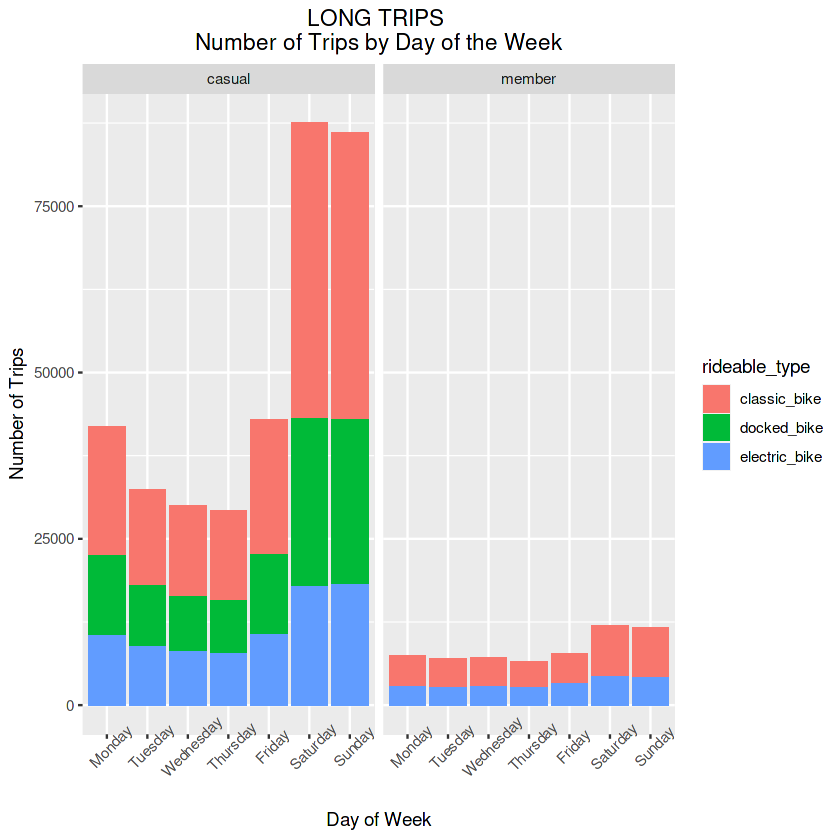

In [32]:
long_trip$start_wkday <- factor(long_trip$start_wkday, 
                                levels=c("Monday", "Tuesday", "Wednesday", 
                                         "Thursday", "Friday", "Saturday", 
                                         "Sunday"))


ggplot(long_trip) + 
  geom_bar(aes(x= start_wkday, fill = rideable_type) ) + 
  facet_wrap(~member_casual) +
  xlab('Weekday') +
  theme(axis.text.x = element_text(angle = 45), 
        plot.title = element_text(hjust = 0.5)) +
  labs(title = "LONG TRIPS \nNumber of Trips by Day of the Week",
       y = "Number of Trips", x="Day of Week")

In [33]:
# Regular Trip
count(regular_trip, member_casual, sort = TRUE)

count(regular_trip, rideable_type)

member_casual,n
<chr>,<int>
member,2955292
casual,2144732


rideable_type,n
<chr>,<int>
classic_bike,3003227
docked_bike,211003
electric_bike,1885794


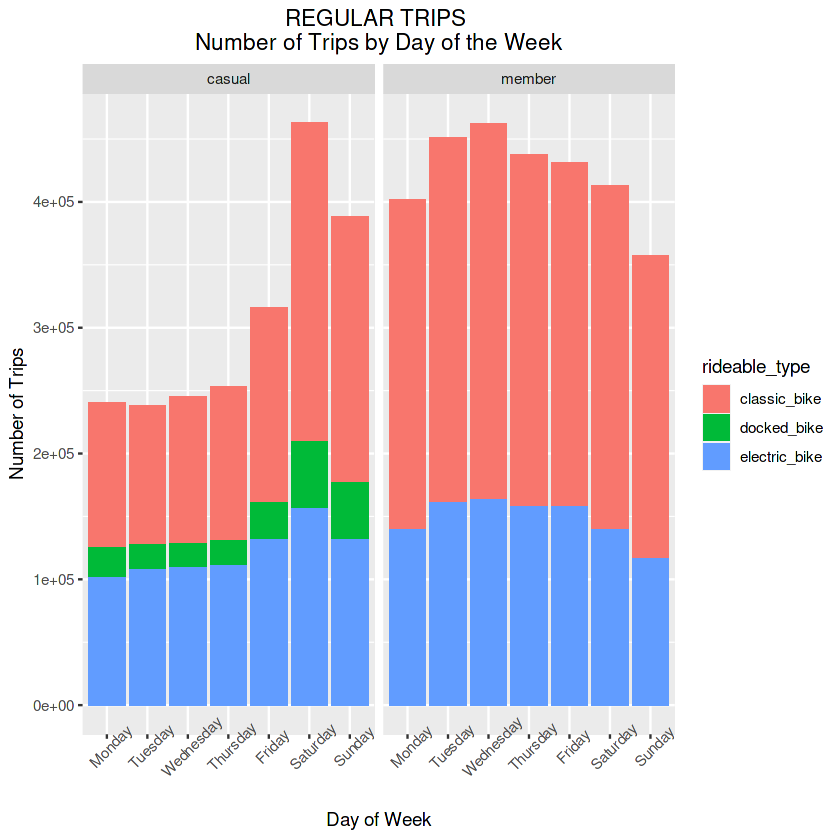

In [34]:
regular_trip$start_wkday <- factor(regular_trip$start_wkday, 
                                   levels=c("Monday", "Tuesday", "Wednesday", 
                                            "Thursday", "Friday", "Saturday", 
                                            "Sunday"))

ggplot(regular_trip) + 
  geom_bar(aes(x=start_wkday, fill = rideable_type )) + 
  facet_wrap(~member_casual) +
  xlab('Weekday') +
  theme(axis.text.x = element_text(angle = 45), 
        plot.title = element_text(hjust = 0.5)) +
  labs(title = "REGULAR TRIPS \nNumber of Trips by Day of the Week",
       y = "Number of Trips", x="Day of Week")

Casual users are responsible for 85.44% of the long trips, using Classic bikes more than any other bike.
This could mean that Casuals tend to keep bikes longer than they should.
For Regular trips, there are slightly more members who take medium length trips with an almost normal distribution for each day of the week.
Our analysis also shows a pattern that Casuals have a preference for weekend rides for both long and short rides.
Docked bikes are the least favourite bike to use for any kind of trip, as we can see Members don’t use docked bikes and have a preference for Classic bikes.

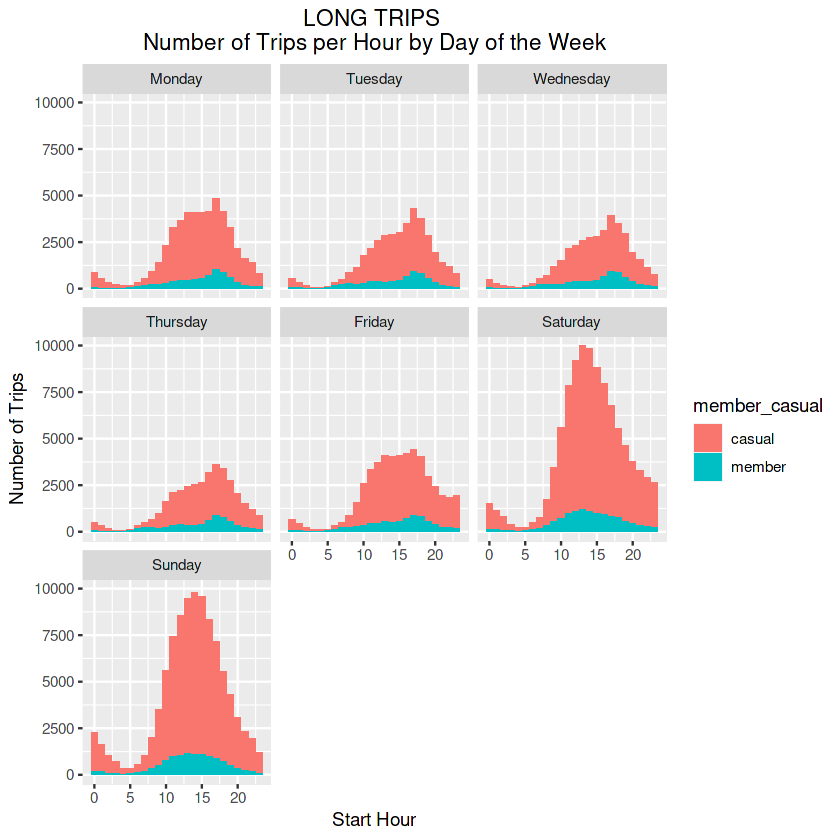

In [35]:
ggplot(long_trip) +
  geom_bar(mapping = aes(x=start_hr, fill= member_casual)) +
  facet_wrap(~start_wkday )+
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(title = "LONG TRIPS \nNumber of Trips per Hour by Day of the Week",
       y="Number of Trips", x = "Start Hour")

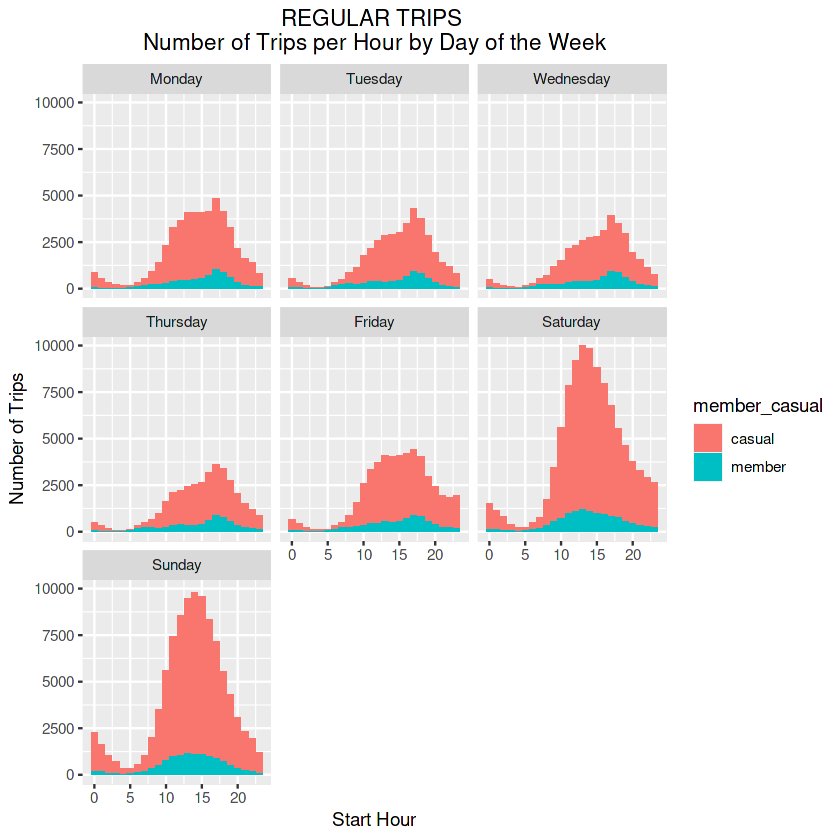

In [36]:
ggplot(long_trip) +
  geom_bar(mapping = aes(x=start_hr, fill= member_casual)) +
  facet_wrap(~start_wkday )+
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(title = "REGULAR TRIPS \nNumber of Trips per Hour by Day of the Week",
       y="Number of Trips", x = "Start Hour")

In a 24hr time frame for each day of the week, it is more obvious that there are a lot more long rides by Casual users on weekends than any other day, having peak traffic between 13:00HRS and 14:00HRS.
Analysis shows that traffic peaks at 17:00HRs for long and regular trips for both Casual riders and Members except on weekends.
Also noticeable is that casual riders have a similar trend line for usage from Monday to Friday, a different but consistent pattern can also be seen for Members for the same days.

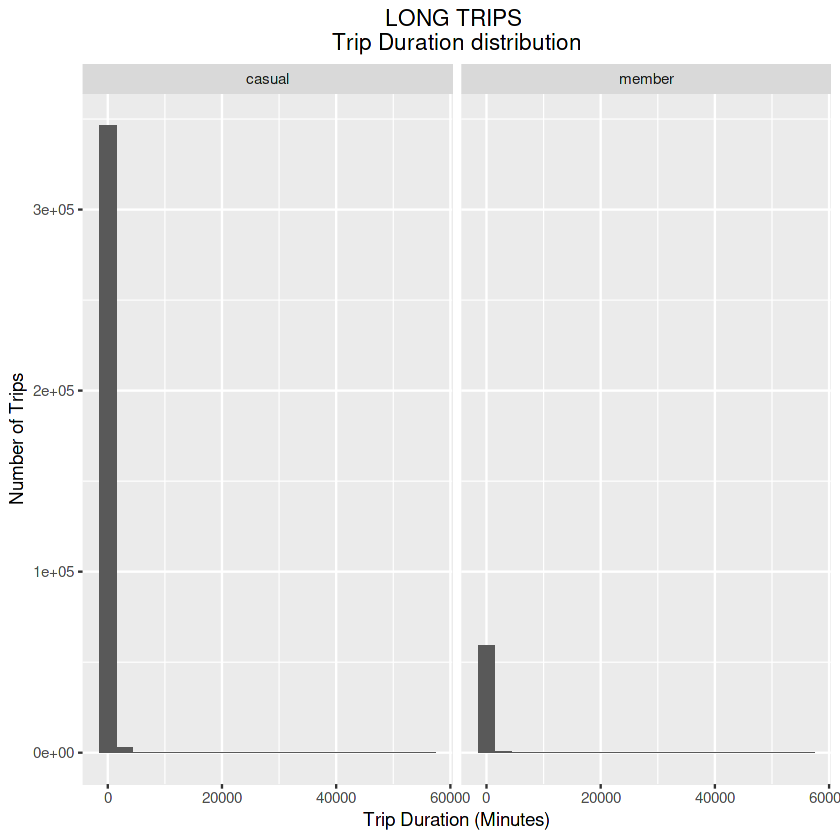

In [37]:
ggplot(long_trip) +
  geom_histogram(mapping = aes(x=trip_minutes), bins = 20) +
  facet_wrap(~member_casual)+
  theme(plot.title = element_text(hjust = 0.5)) + 
  labs(title = "LONG TRIPS \nTrip Duration distribution",
       y="Number of Trips", x = "Trip Duration (Minutes)")

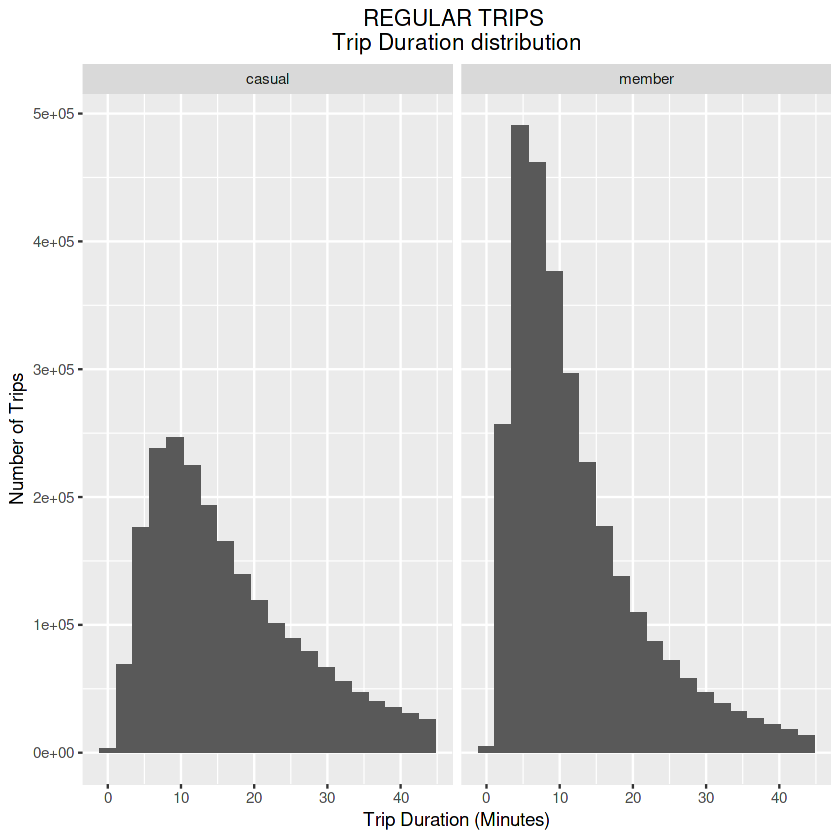

In [38]:
ggplot(regular_trip) +
  geom_histogram(mapping = aes(x=trip_minutes), bins = 20) +
  facet_wrap(~member_casual)+
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(title = "REGULAR TRIPS \nTrip Duration distribution",
       y="Number of Trips", x = "Trip Duration (Minutes)")

We see that trips between 0 and 15 minutes are the most common duration for trips taken by both members and casuals when considering regular length trips.
The Long trip histogram shows no valuable information we were not previously aware of.

`summarise()` has grouped output by 'member_casual'. You can override using the `.groups` argument.



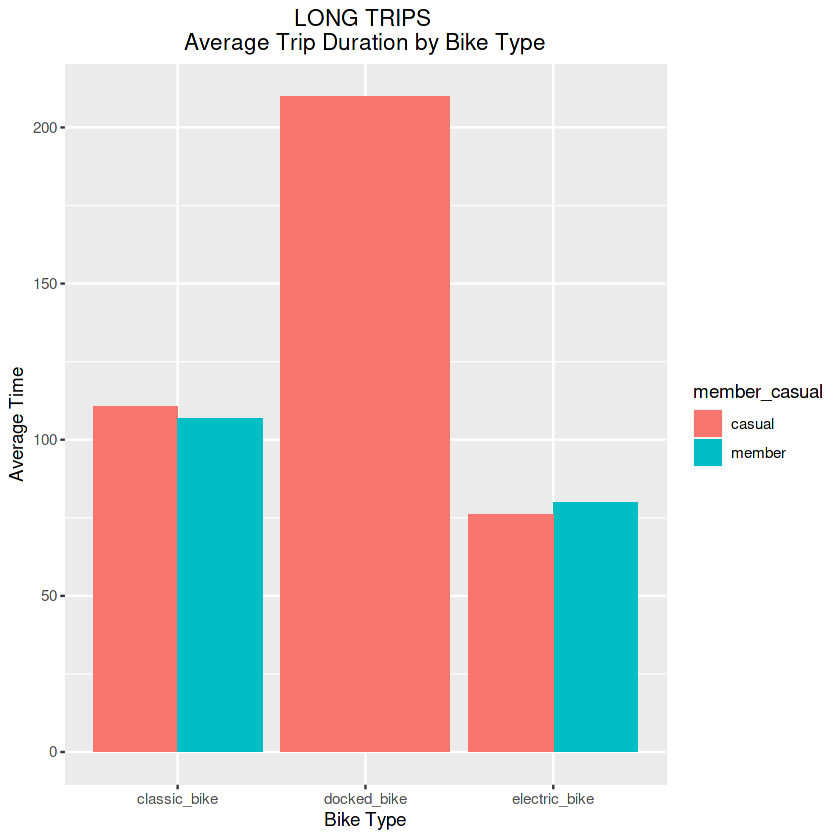

In [39]:
long_trip %>%
  group_by(member_casual, rideable_type) %>%
  summarise(avg_time = mean(trip_minutes), 
            total_time = sum(trip_minutes)) %>% 
  arrange(desc(avg_time)) %>%
  ggplot() +
  geom_col(mapping = aes(x=rideable_type, y=avg_time, fill=member_casual)
           ,position="dodge") +
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(title = "LONG TRIPS \nAverage Trip Duration by Bike Type",
       y="Average Time", x= "Bike Type")

`summarise()` has grouped output by 'member_casual'. You can override using the `.groups` argument.



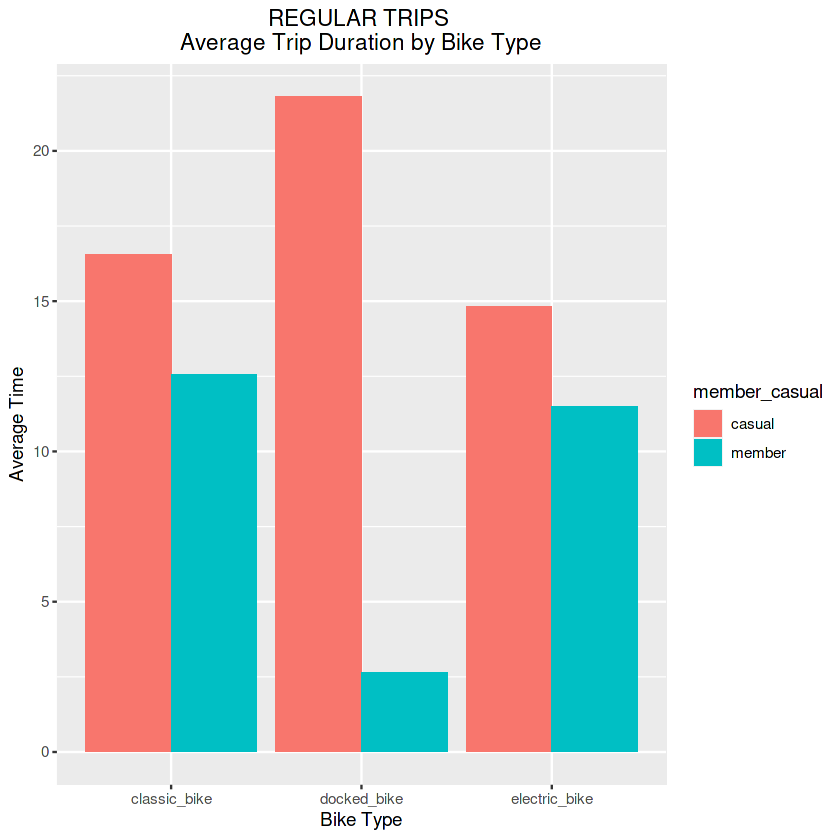

In [40]:
regular_trip %>%
  group_by(member_casual, rideable_type) %>%
  summarise(avg_time = mean(trip_minutes), 
            total_time = sum(trip_minutes)) %>% 
  arrange(desc(avg_time)) %>%
  ggplot() +
  geom_col(mapping = aes(x=rideable_type, y=avg_time, fill=member_casual)
           ,position="dodge")+
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(title = "REGULAR TRIPS \nAverage Trip Duration by Bike Type",
       y="Average Time", x= "Bike Type")

On average, Casual riders take longer-regular trips than members.
Confirmation that for regular trips, members have an maximum average trip duration of 12.6 minutes and that is while using classic bikes.
Surprisingly, Casuals tend to take longer-regular trips, 21.8 minutes while using docked bikes, even as it is the least favourite bike of any class.
For our long trips, docked bikes seem to take the cake by averaging over 200 per trip, this would be as a result of the extreme outliers contained in this dataframe. This outlier could be caused by riders not knowing how to properly dock bikes after use. Classic bikes have the highest average trip duration by both Members and Casuals

`summarise()` has grouped output by 'member_casual'. You can override using the `.groups` argument.



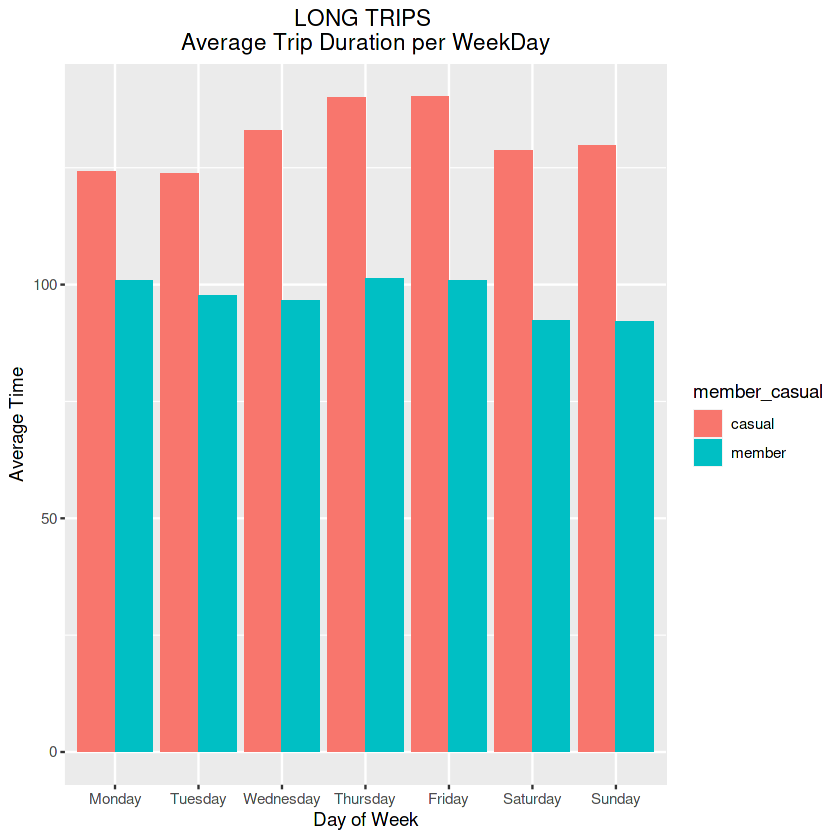

In [41]:
long_trip %>%
  group_by(member_casual, start_wkday) %>%
  summarise(avg_time = mean(trip_minutes)) %>% 
  arrange(desc(avg_time)) %>%
  ggplot() +
  geom_col(mapping = aes(x=start_wkday, y=avg_time, fill=member_casual)
           ,position="dodge")+
  ggtitle("") + 
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(title = "LONG TRIPS \nAverage Trip Duration per WeekDay",
       y="Average Time", x= "Day of Week")

`summarise()` has grouped output by 'member_casual'. You can override using the `.groups` argument.



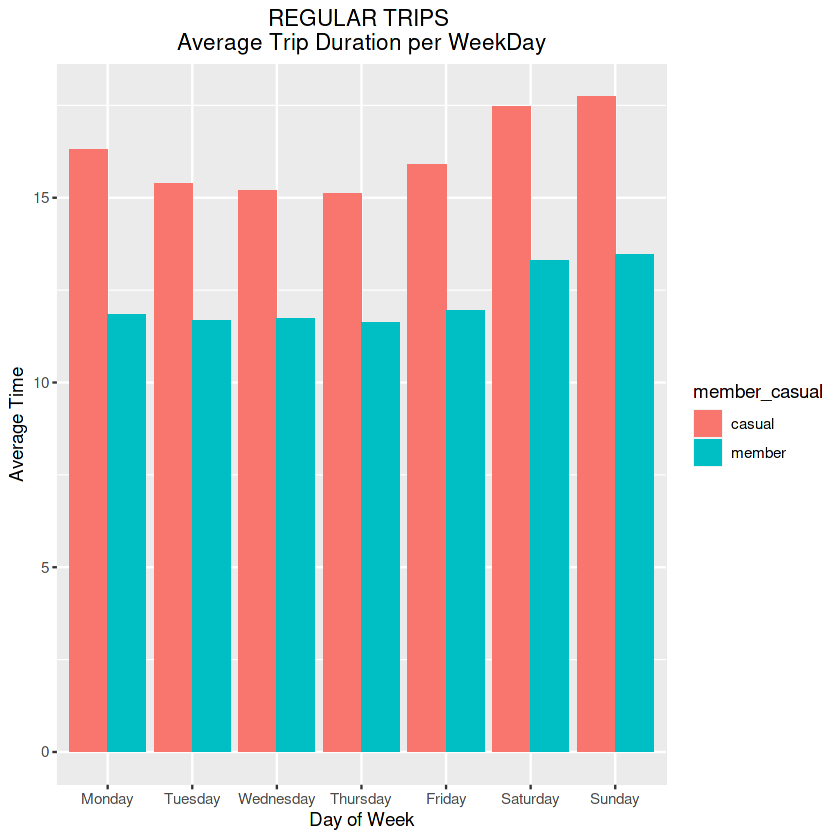

In [42]:
regular_trip %>%
  group_by(member_casual, start_wkday) %>%
  summarise(avg_time = mean(trip_minutes)) %>% 
  arrange(desc(avg_time)) %>%
  ggplot() +
  geom_col(mapping = aes(x=start_wkday, y=avg_time, fill=member_casual)
           ,position="dodge")+
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(title = "REGULAR TRIPS \nAverage Trip Duration per WeekDay",
       y="Average Time", x= "Day of Week")

As seen earlier that there are more of both riders travelling on weekends, we can also see here that they have their highest trip duration for regular trips on weekends at 17.7 and 17.5 minutes for Sunday and Saturday respectively for Casuals while Members spend roughly 4 minutes less.
Another observation is Thursdays is consistent between both riders with the lowest average trip duration.
For long trips we see that Casuals have range for average trip duration of roughly 10 minutes, higher than regular trips. while Casuals have a 39 minutes range. We see a divergence from the usual trend of weekends winning in every analysis carried out since with Thursday & Fridays having the highest average Trip duration for Casuals and Members. This would mean that our extreme Trip duration values come from these days.

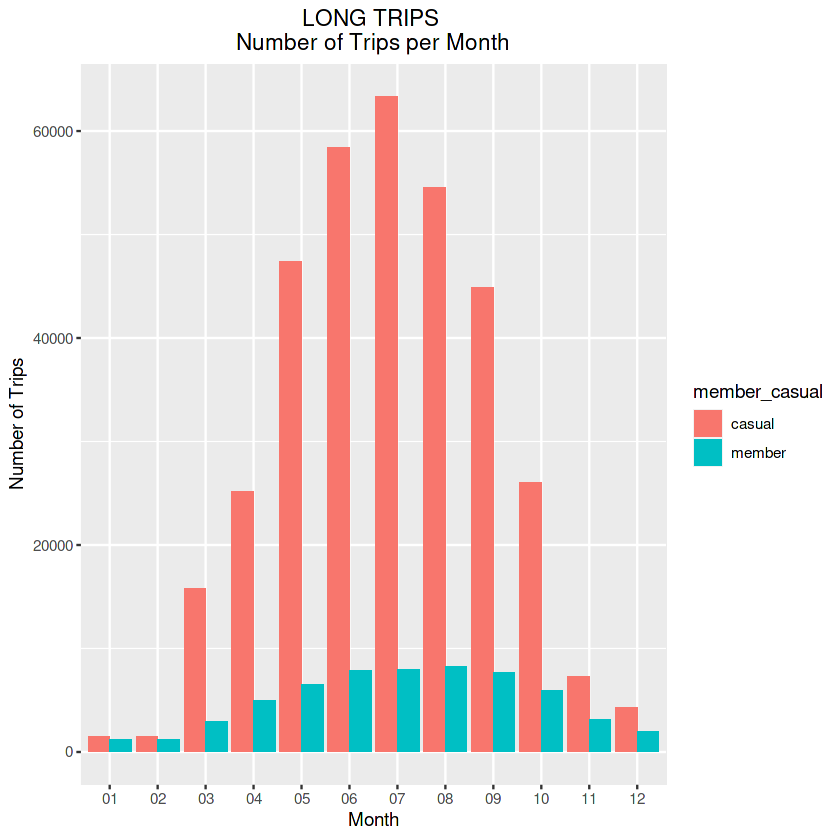

In [43]:
long_trip %>%
  mutate(month = format(started_at, "%m")) %>%
  ggplot() +
  geom_bar(mapping = aes(x=month, fill=member_casual)
           ,position="dodge") +
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(title = "LONG TRIPS \nNumber of Trips per Month",
       y="Number of Trips", x= "Month")

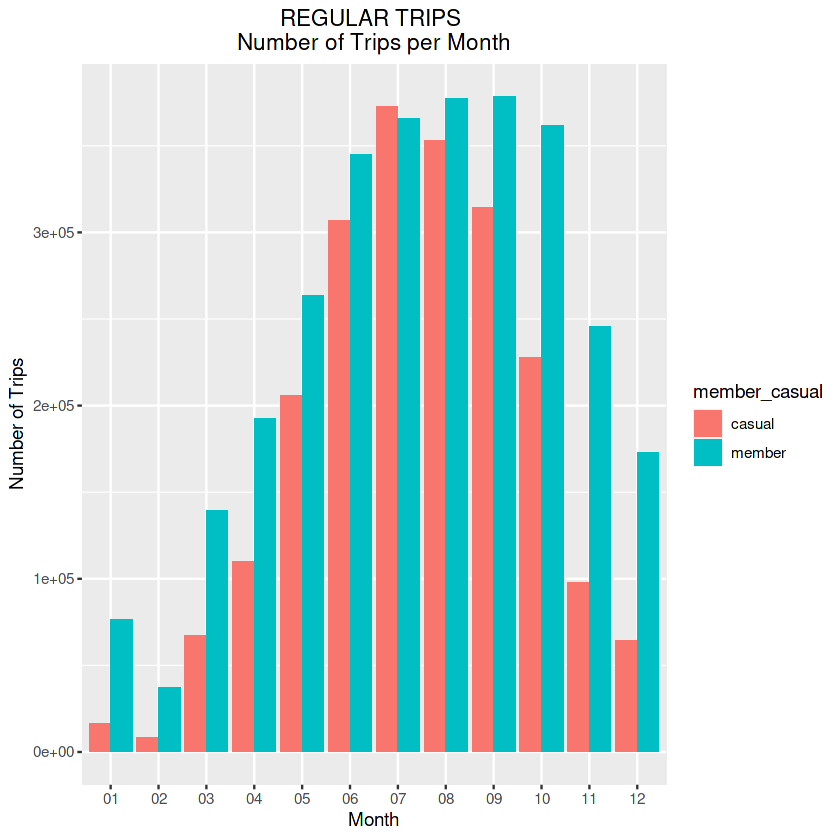

In [44]:
regular_trip %>%
  mutate(month = format(started_at, "%m")) %>%
  ggplot() +
  geom_bar(mapping = aes(x=month, fill=member_casual)
           ,position="dodge") +
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(title = "REGULAR TRIPS \nNumber of Trips per Month",
       y="Number of Trips", x= "Month")

For both long and regular trips we see that we have fewer trips taking place from December to March for Members and Casual riders, a quick research on weather patterns shows that these are Winter months, so it would be difficult to ride in the snow and extremely cold to be outdoors on a bike.
For Regular trips, it is also noticeable that June through September have the most trips for any user class, as these months are in the summer, the weather is conducive for riding and a lot more people are on holidays. The month of July also has more Casual trips than Members, historical data for the month would have to be investigated to confirm if this is a recurring trend.
For long trips, there’s a similar trend for volume of trips for each month, with the volume of rides peaking in July too.

`summarise()` has grouped output by 'month'. You can override using the `.groups` argument.



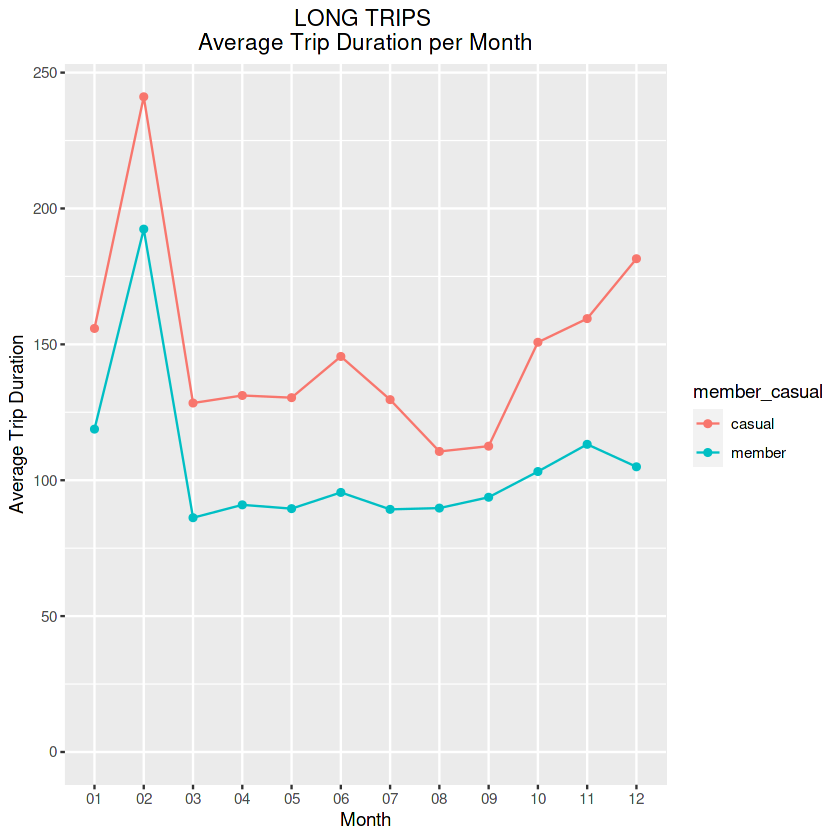

In [45]:
long_trip %>%
  mutate(month = format(started_at, "%m")) %>%
  group_by(month, member_casual) %>%
  summarise(avg_time = mean(trip_minutes)) %>%
  ggplot(aes(x= month, y= avg_time, group= member_casual)) +
  geom_line(aes(color = member_casual) ) +
  geom_point(aes(color = member_casual)) +
  scale_y_continuous(limits = c(0, NA)) +
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(title = "LONG TRIPS \nAverage Trip Duration per Month",
       y="Average Trip Duration", x= "Month")

`summarise()` has grouped output by 'month'. You can override using the `.groups` argument.



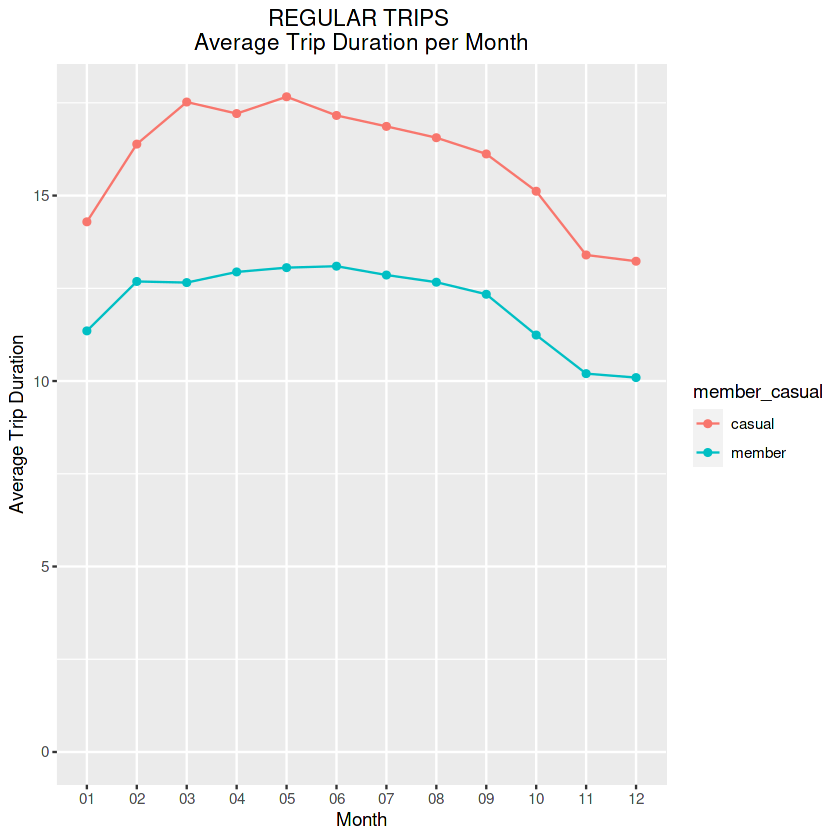

In [46]:
regular_trip %>%
  mutate(month = format(started_at, "%m")) %>%
  group_by(month, member_casual) %>%
  summarise(avg_time = mean(trip_minutes)) %>%
  ggplot(aes(x=month, y=avg_time, group=member_casual)) +
  geom_line(aes(color=member_casual) ) +
  geom_point(aes(color=member_casual)) +
  scale_y_continuous(limits = c(0, NA)) +
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(title = "REGULAR TRIPS \nAverage Trip Duration per Month",
       y="Average Trip Duration", x= "Month")

While the average trip duration for Casuals is higher than for Members, we see they almost mirror each other, peaking in May and having their least in December. While we saw earlier that there are more trips in the summer, riders take short trips, this could be because the weather is too hot to engage is physical activities like cycling for too long.
For long trips we see the Average trip duration peak in February, also higher values in the Winter season than other months. This means people keep bikes longer and could be as a result of snow making it difficult for people to move around and return bikes. We also note that average trip duration are quite low during the summer.
Further investigation should be carried out to confirm the causes of these points.

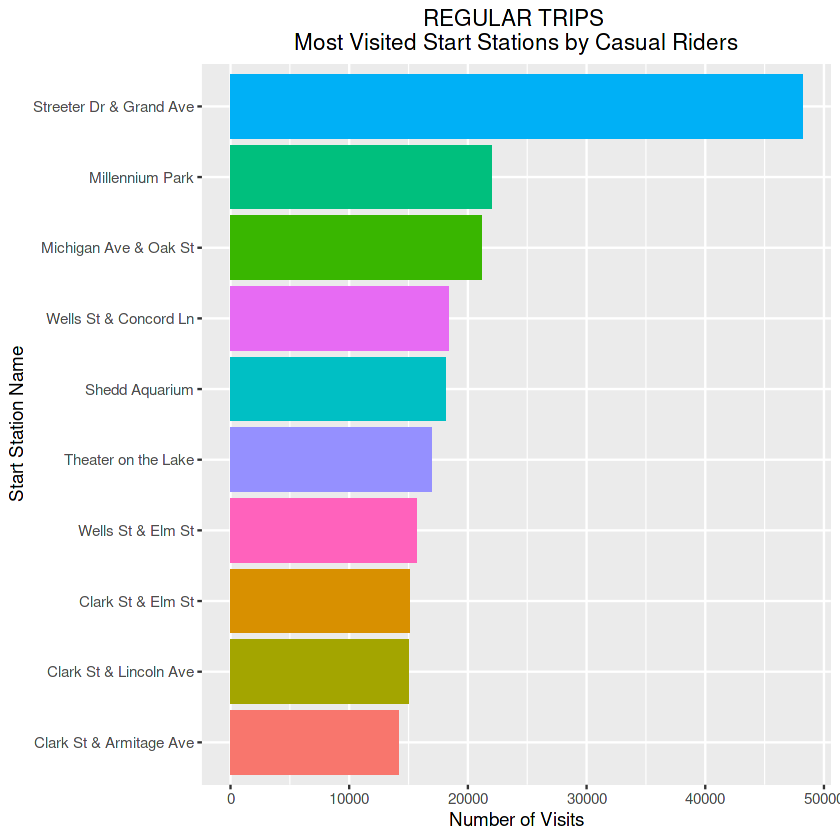

In [47]:
regular_trip %>%  
  filter(member_casual == "casual", 
         start_station_name != "missing station") %>% 
  group_by(start_station_name) %>%
  summarise(total = n()) %>%
  arrange( desc(total) ) %>%
  head(10) %>%
  ggplot()+
  geom_col(mapping = aes(x=total, y=reorder(start_station_name, total), 
                         fill=start_station_name)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "none") +
  labs(title = "REGULAR TRIPS \nMost Visited Start Stations by Casual Riders",
       y = "Start Station Name", x = "Number of Visits")

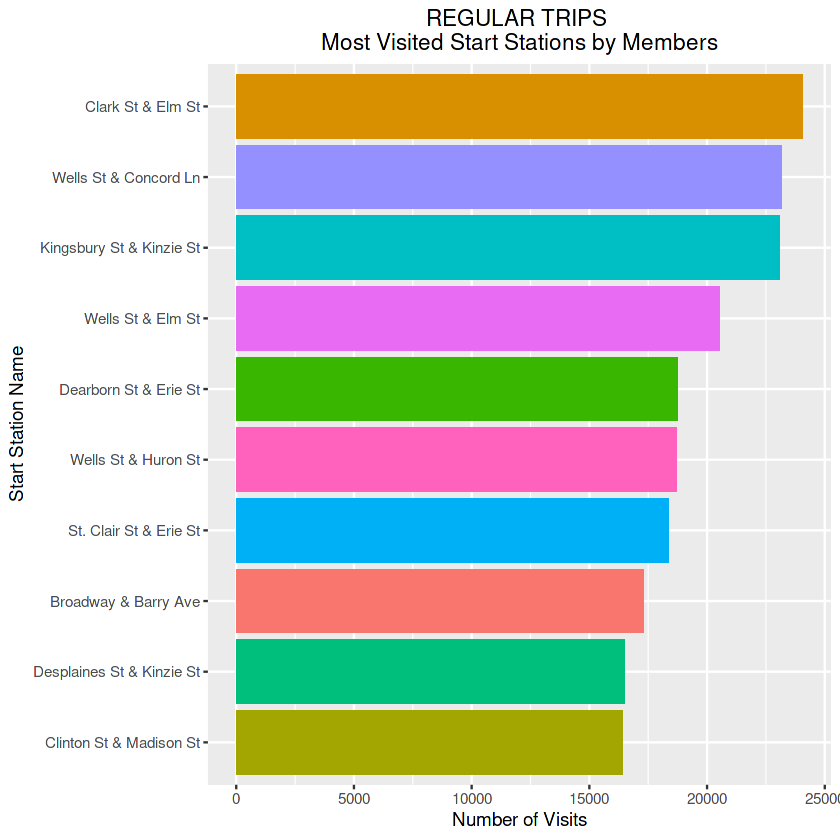

In [48]:
regular_trip %>%  
  filter(member_casual == "member", 
         start_station_name != "missing station") %>% 
  group_by(start_station_name) %>%
  summarise(total = n()) %>%
  arrange( desc(total) ) %>%
  head(10) %>%
  ggplot()+
  geom_col(mapping = aes(x=total, y=reorder(start_station_name, total), 
                         fill=start_station_name)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "none") +
  labs(title = "REGULAR TRIPS \nMost Visited Start Stations by Members",
       y = "Start Station Name", x = "Number of Visits")

After excluding missing stations, the visualization shows that Casual and Members have very different locations to start their trip, having only 3 stations in common. This could strong difference could be a matter of preference but I would prefer to hypothesize that these values are more dependent on where riders live, work and carry out most of their daily activities. As seen in the visual Streeter Dr & Grand Ave visited by Casuals has the most visits of the two class of users.

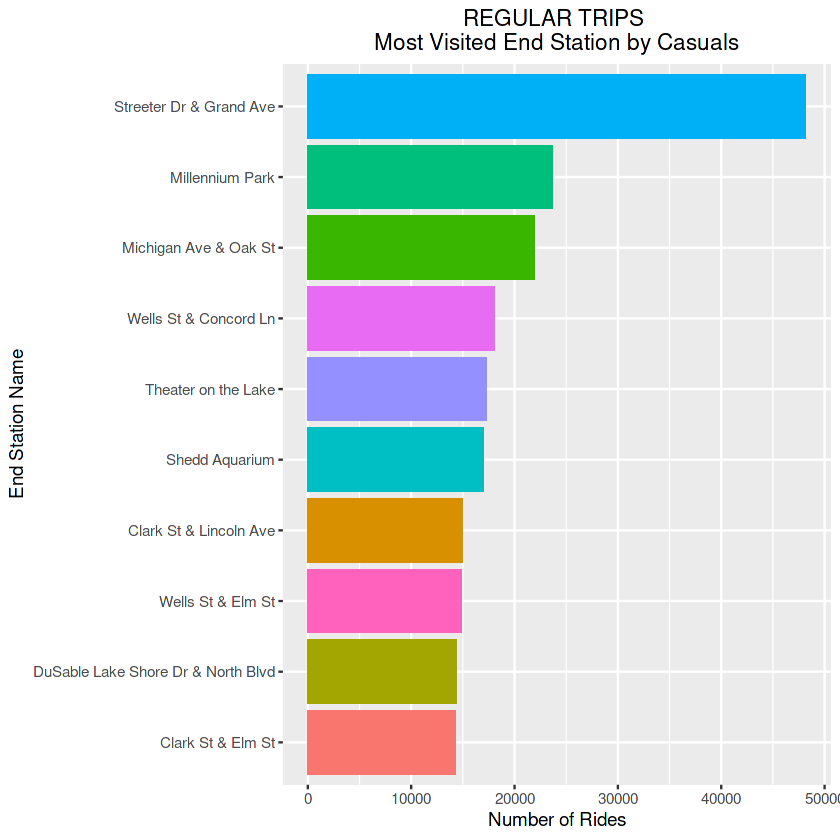

In [49]:
regular_trip %>%  
  filter(member_casual == "casual", 
         end_station_name != "missing station") %>% 
  group_by(end_station_name) %>%
  summarise(total = n()) %>%
  arrange( desc(total) ) %>%
  head(10) %>%
  ggplot()+
  geom_col(mapping = aes(x=total, y=reorder(end_station_name, total), 
                         fill=end_station_name)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "none") +
  labs(title = "REGULAR TRIPS \nMost Visited End Station by Casuals",
       y = "End Station Name", x = "Number of Rides")

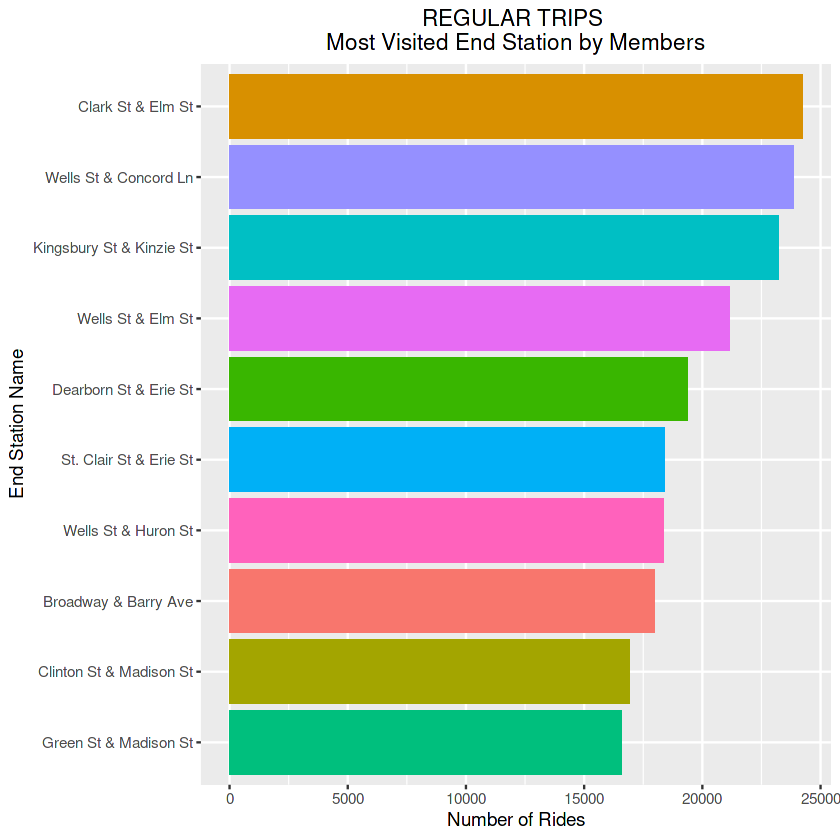

In [50]:
regular_trip %>%  
  filter(member_casual == "member", 
         end_station_name != "missing station") %>% 
  group_by(end_station_name) %>%
  summarise(total = n()) %>%
  arrange( desc(total) ) %>%
  head(10) %>%
  ggplot()+
  geom_col(mapping = aes(x=total, y=reorder(end_station_name, total), 
                         fill=end_station_name)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "none") +
  labs(title = "REGULAR TRIPS \nMost Visited End Station by Members",
       y = "End Station Name", x = "Number of Rides")

We can see that for Members and Casuals, stations where rides ended are almost the same as where trips started, with only 1 station in from the Start station changing in the end station.
Streeter Dr & Grand Ave by Casuals still is the most visited station when looking at where trips end.

`summarise()` has grouped output by 'start_station_name'. You can override using the `.groups` argument.



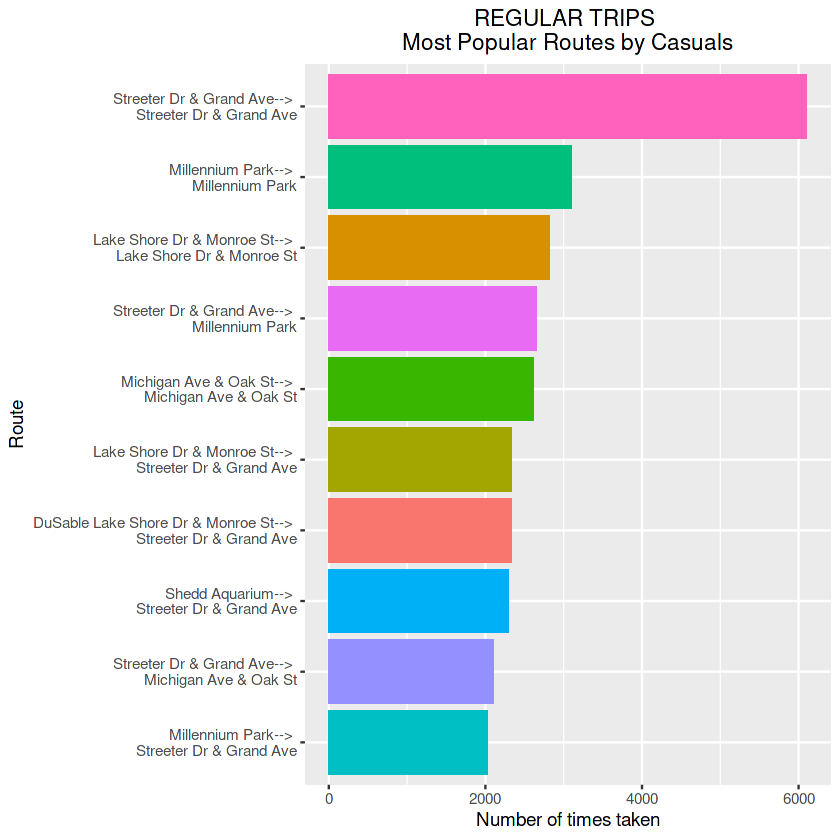

In [51]:
regular_trip %>%  
  filter(member_casual == "casual", 
         start_station_name != "missing station", 
         end_station_name != "missing station") %>% 
  group_by(start_station_name, end_station_name) %>%
  summarise(total = n()) %>%
  mutate(route = 
           paste(start_station_name,end_station_name,sep = "--> \n")) %>%
  arrange( desc(total) ) %>%
  head(10) %>%
  ggplot()+
  geom_col(mapping = aes(x=total, y=reorder(route, total), 
                         fill=route)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "none") +
  labs(title = "REGULAR TRIPS \nMost Popular Routes by Casuals",
       y = "Route", x = "Number of times taken")

`summarise()` has grouped output by 'start_station_name'. You can override using the `.groups` argument.



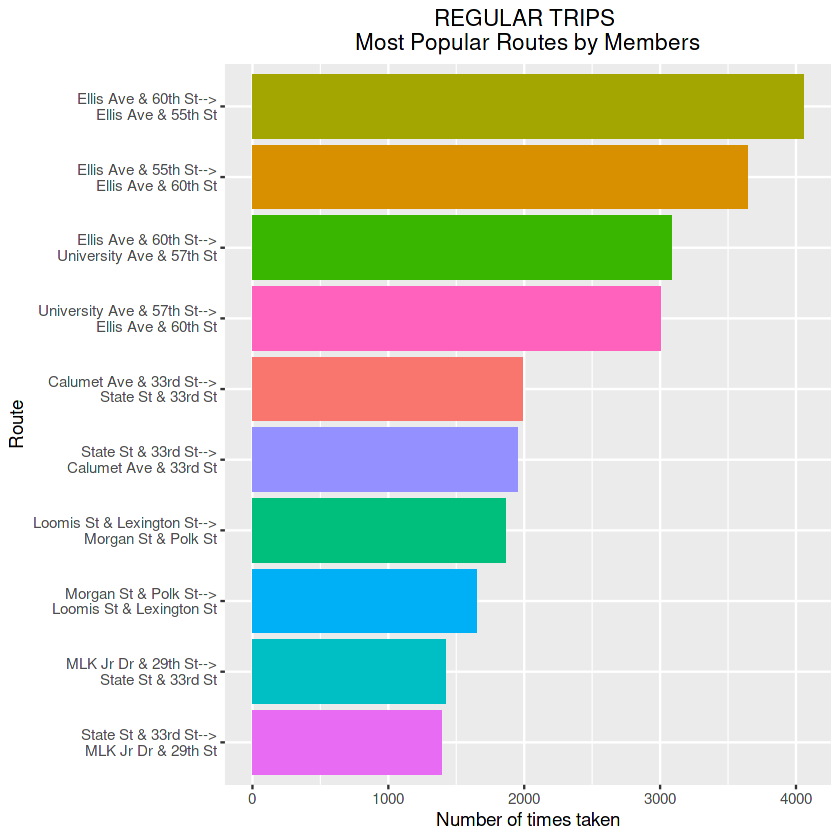

In [52]:
regular_trip %>%  
  filter(member_casual == "member", 
         start_station_name != "missing station", 
         end_station_name != "missing station") %>% 
  group_by(start_station_name, end_station_name) %>%
  summarise(total = n()) %>%
  mutate(route = 
           paste(start_station_name,end_station_name,sep = "-->\n")) %>%
  arrange( desc(total) ) %>%
  head(10) %>%
  ggplot()+
  geom_col(mapping = aes(x=total, y=reorder(route, total), 
                         fill=route)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "none") +
  labs(title = "REGULAR TRIPS \nMost Popular Routes by Members",
       y = "Route", x = "Number of times taken")

4 of our top 5 routes by casuals, start and end in the same station. We can also see that Streeter Dr & Grand Ave appears to be the most popular station for Casuals, occuring 8 times in our top 10 routes.
The stations in most popular routes by Members are very different from the stations visited the most as shown previously.

## CONCLUSION

The data provided did not provide information specific to unique riders to enable us better understand how each individual accessed and made use of our bikes.
The data provided gave information on unique rides/trips, data over a longer period (5 years) should have been provided to better investigate and confirm patterns that were noticed. With the information provided, I would suggest that to convert Casual riders to Members the following should be considered;

* Increase charge for late returns by Casuals.
* Run promotion giving extra time for members rides during the Summer.
* Run ads at the most visited stations by Casuals.
* Provide promotion for rides between the most travelled routes.
* Give priority access for Members during Casual peak time and months.
* Run ad campaigns for Summer riders.
* Increase minutes for weekend trips by members.
* Increase rental costs for weekend trips by Casual riders.